<a href="https://colab.research.google.com/github/Coldeye2020/colab/blob/main/HW01/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 63.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 86.1MB/s]


# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# 新导入两个包，前者用于划分Train和Develepment
from sklearn.model_selection import train_test_split
import pandas as pd

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True # 固定住网络，配合seed一起用，可以保证每次跑出来的结果都绝对是一样的
torch.backends.cudnn.benchmark = False  # 这里是不使用CudaNN优化，如果网络还没确定，结构还要调整的话就不要进行优化，不然会更慢
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data
data_tr = pd.read_csv(tr_path) #读取训练数据
data_tt = pd.read_csv(tt_path) #读取测试数据

In [4]:
data_tr.columns

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

In [5]:
data_tt.columns

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

In [6]:
data_tr.drop(['id'], axis = 1, inplace = True)
data_tt.drop(['id'], axis = 1, inplace = True)

In [7]:
cols = list(data_tr.columns)  #拿到特征列名称，返回的是一个Index对象
data_tr.columns

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli',
       'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop',
       'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious',
       'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1',
       'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1',
       'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1',
       'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1',
       'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2',
       'nohh_cmnty_cli.2', 'wearing_m

In [9]:
WI_index = cols.index('WI')
WI_index

39

In [12]:
data_tr.iloc[:, 40:].describe() #从上面可以看出wi 列后面是cli, 所以列索引从40开始， 并查看这些数据分布

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,10.352273,2.393285,18.074684,13.075498,19.213321,64.633769,44.519474,16.300893,0.994568,1.019135,29.529305,24.402875,89.736737,8.861371,31.664651,55.198075,16.635440,36.176886,10.304595,2.389372,18.071667,13.067127,19.228457,64.734139,44.544124,16.366695,0.997986,1.022472,29.610807,24.477913,89.790227,8.830759,31.624272,55.119903,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,4.698705,1.053270,2.248750,1.621328,2.706605,6.232239,5.265787,7.637823,0.420114,0.423538,9.082940,8.443146,5.366067,3.389310,4.916168,4.524887,5.660085,6.664218,4.692479,1.053237,2.249864,1.625269,2.707148,6.226622,5.248787,7.627538,0.420205,0.423705,9.070537,8.437044,5.351574,3.377722,4.901857,4.524442,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.330064,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.356322,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,6.653427,1.720601,16.420485,11.943953,17.292063,59.529326,40.520369,10.200722,0.676205,0.699773,23.264324,18.607342,86.386111,6.168986,28.202745,51.403036,13.248788,30.646955,6.605724,1.715372,16.423140,11.933745,17.303887,59.703583,40.533768,10.251453,0.680065,0.703390,23.307794,18.644297,86.436468,6.159286,28.187875,51.262363,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,9.802380,2.204258,17.685476,12.963659,18.735807,65.688024,43.911769,15.479766,0.917343,0.942587,29.061296,23.905188,90.859943,8.274067,32.108420,55.129326,16.293314,36.169954,9.738629,2.203602,17.684970,12.956723,18.745824,65.783579,43.947131,15.572281,0.920815,0.948001,29.137273,24.010817,90.912271,8.251691,32.051128,54.990445,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932258,43.997637,15.646480


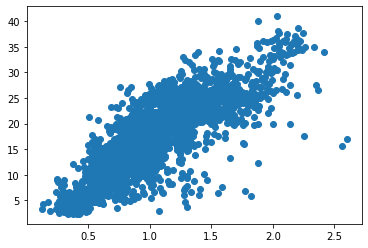

In [15]:
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'tested_positive.2']) #肉眼分析cli特征与目标之间相关性

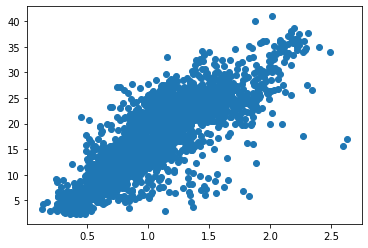

In [16]:
plt.scatter(data_tr.loc[:, 'ili'], data_tr.loc[:, 'tested_positive.2']) #肉眼分析ili特征与目标之间相关性

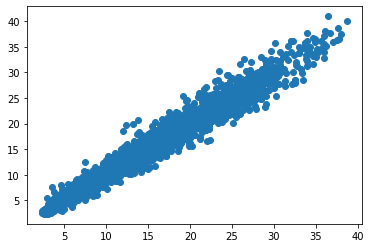

In [18]:
plt.scatter(data_tr.loc[:,  'tested_positive'], data_tr.loc[:, 'tested_positive.2']) #day1 目标值与day3目标值相关性，线性相关的

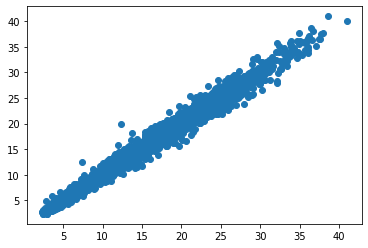

In [19]:
plt.scatter(data_tr.loc[:,  'tested_positive.1'], data_tr.loc[:, 'tested_positive.2']) #day2 目标值与day3目标值相关性，线性相关的

In [21]:
data_tr.iloc[:, 40:].corr()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,-0.107406,-0.095964,0.087305,-0.364165,-0.143318,-0.209020,-0.042033,-0.367103,0.273874,0.098033,0.100928,0.218502,0.537608,0.839122,0.980379,0.976171,0.896211,0.885178,-0.101056,-0.097092,0.087080,-0.367850,-0.147491,-0.216168,-0.051724,-0.371063,0.256712,0.088676,0.099487,0.223326,0.543373,0.839929,0.957059,0.952707,0.898067,0.887103,-0.094664,-0.097903,0.085913,-0.370197,-0.151291,-0.222834,-0.060308,-0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,-0.109015,-0.106934,0.086355,-0.357443,-0.142082,-0.207210,-0.043535,-0.356652,0.281974,0.102715,0.107079,0.212931,0.532217,0.829756,0.977225,0.980473,0.892667,0.881292,-0.102606,-0.107662,0.085966,-0.361304,-0.146353,-0.214354,-0.052961,-0.360574,0.264872,0.093371,0.105446,0.217739,0.537874,0.831129,0.954996,0.956979,0.894564,0.883263,-0.096315,-0.107903,0.084708,-0.363795,-0.150141,-0.220942,-0.061298,-0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,-0.035441,-0.069595,0.079219,-0.472746,-0.247043,-0.293775,-0.124151,-0.432142,0.336748,0.184739,0.198176,0.344457,0.552431,0.880187,0.887944,0.884020,0.998356,0.995176,-0.030237,-0.069270,0.074972,-0.474799,-0.250349,-0.297071,-0.130729,-0.432765,0.323053,0.182383,0.201034,0.347562,0.557364,0.880416,0.881768,0.877550,0.995396,0.991738,-0.025367,-0.069043,0.069933,-0.476538,-0.253615,-0.300062,-0.136937,-0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,-0.046063,-0.061914,0.097756,-0.465374,-0.238106,-0.280916,-0.116761,-0.423773,0.344074,0.190062,0.197661,0.340192,0.524022,0.869674,0.877606,0.873424,0.996165,0.998259,-0.040738,-0.062039,0.093529,-0.467316,-0.241687,-0.284398,-0.123252,-0.424445,0.331791,0.188544,0.200843,0.343024,0.529514,0.870315,0.872292,0.867896,0.993750,0.995093,-0.035759,-0.062137,0.088394,-0.469026,-0.245265,-0.287482,-0.129474,-0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,-0.107406,-0.109015,-0.035441,-0.046063,1.000000,-0.220808,-0.735649,-0.691597,-0.788714,-0.807623,-0.894970,0.131350,0.232620,-0.070022,0.422058,0.843990,0.354130,-0.049350,-0.121569,-0.123680,-0.046423,-0.056529,0.998287,-0.220442,-0.737554,-0.688627,-0.787245,-0.805468,-0.892267,0.132301,0.217574,-0.069369,0.424822,0.842499,0.347359,-0.059477,-0.135146,-0.137841,-0.058149,-0.067698,0.995953,-0.219916,-0.739112,-0.685437,-0.785281,-0.802659,-0.889021,0.133487,0.204031,-0.067720,0.427533,0.840528,0.340101,-0.069531
travel_outside_state,-0.095964,-0.106934,-0.069595,-0.061914,-0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,0.324270,-0.198308,-0.023175,0.058548,-0.376858,-0.136811,-0.096444,-0.113726,-0.091186,-0.102645,-0.063619,-0.055823,-0.220397,0.995838,0.268864,0.252461,0.288160,0.343854,0.322149,-0.201241,-0.011044,0.061782,-0.374146,-0.134507,-0.094679,-0.105467,-0.086332,-0.097991,-0.057164,-0.049281,-0.219423,0.989310,0.275348,0.249670,0.288098,0.336937,0.319736,-0.203611,0.001592,0.064425,-0.370776,-0.131961,-0.093096,-0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,-0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,0.

In [27]:
data_corr = data_tr.iloc[:, 40:].corr() #上面手动分析太累，还是利用corr方法自动分析
target_corr = data_corr['tested_positive.2']
target_corr

cli                       0.838504
ili                       0.830527
hh_cmnty_cli              0.879724
nohh_cmnty_cli            0.869938
wearing_mask             -0.069531
travel_outside_state     -0.097303
work_outside_home         0.034865
shop                     -0.410430
restaurant               -0.157945
spent_time               -0.252125
large_event              -0.052473
public_transit           -0.448360
anxious                   0.173295
depressed                 0.037689
felt_isolated             0.082182
worried_become_ill        0.262211
worried_finances          0.475462
tested_positive           0.981165
cli.1                     0.838224
ili.1                     0.829200
hh_cmnty_cli.1            0.879438
nohh_cmnty_cli.1          0.869278
wearing_mask.1           -0.065600
travel_outside_state.1   -0.100407
work_outside_home.1       0.037930
shop.1                   -0.412705
restaurant.1             -0.159121
spent_time.1             -0.255714
large_event.1       

In [44]:
feature = target_corr[target_corr>0.8]
feature_cols = feature.index.tolist()
feature_cols.pop()
feature_selected = [cols.index(col) for col in feature_cols]
del feature_selected[0]
feature_selected

[41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

# **Some Utilities**

You do not need to modify this part.

In [55]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(15, 12))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [86]:
feats = list(range(20)) + [3]
feats

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 3]

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [57]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
            path,
            mu,
            std,
            mode='train',
            target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp)) # 按行读入csv，每一行都是一个list，所有list又合起来组成一个大list（二维list）
            data = np.array(data[1:])[:, 1:].astype(float)  # 最开始一行是特征说明，去掉后转换为array，然后每行第一列是id，去掉
        
        if not target_only:
            feats = list(range(93)) # 对于training set一共有94条属性，每天有18条属性（40 + 3 * 18）
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + feature_selected

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats] 
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            # if mode == 'train':
            #     indices = [i for i in range(len(data)) if i % 10 != 0]
            # elif mode == 'dev':
            #     indices = [i for i in range(len(data)) if i % 10 == 0]
            
            indices_tr, indices_dev = train_test_split([i for i in range(data.shape[0])], test_size = 0.3, random_state = 0)
            if self.mode == 'train':
                indices = indices_tr
            elif self.mode == 'dev':
                indices = indices_dev
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # self.data[:, 40:] = \
        #     (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, 40:].std(dim=0, keepdim=True)

        if self.mode == 'train':
            self.mu = self.data[:, 40:].mean(dim=0, keepdim=True)
            self.std = self.data[:, 40:].std(dim=0, keepdim=True)
        else:
            self.mu = mu
            self.std = std

        self.data[:, 40:] = (self.data[:, 40:] - self.mu) / self.std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [65]:
def prep_dataloader(path, mu, std, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mu, std, mode=mode, target_only=target_only)  # Construct dataset
    if mode == 'train':
      mu = dataset.mu
      std = dataset.std
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader, mu, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [66]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean') # 其实默认就是Mean

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        eps = 1e-6
        l2_reg = 0
        alpha = 0.0001
        # 这是L2正则化的代码，一般只对w进行正则化，强烈建议记下来
        for name, w in self.net.named_parameters():
             if 'weight'  in name:
                 l2_reg += alpha * torch.norm(w, p = 2).to(device)
        return torch.sqrt(self.criterion(pred, target) + eps) + l2_reg

# **Train/Dev/Test**

## **Training**

In [67]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [68]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [69]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [70]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [71]:
tr_set, tr_mu, tr_std = prep_dataloader(tr_path, None, None ,'train', config['batch_size'], target_only=target_only)
dv_set, mu_none, std_none = prep_dataloader(tr_path, tr_mu, tr_std, 'dev', config['batch_size'], target_only=target_only)
tt_set, mu_none, std_none = prep_dataloader(tt_path, tr_mu, tr_std, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (1890 samples found, each dim = 53)
Finished reading the dev set of COVID19 Dataset (810 samples found, each dim = 53)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 53)


In [72]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [73]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.8108)
Saving model (epoch =    2, loss = 17.7048)
Saving model (epoch =    3, loss = 17.5715)
Saving model (epoch =    4, loss = 17.4200)
Saving model (epoch =    5, loss = 17.2511)
Saving model (epoch =    6, loss = 17.0623)
Saving model (epoch =    7, loss = 16.8474)
Saving model (epoch =    8, loss = 16.5981)
Saving model (epoch =    9, loss = 16.3030)
Saving model (epoch =   10, loss = 15.9539)
Saving model (epoch =   11, loss = 15.5298)
Saving model (epoch =   12, loss = 15.0216)
Saving model (epoch =   13, loss = 14.4148)
Saving model (epoch =   14, loss = 13.6962)
Saving model (epoch =   15, loss = 12.8542)
Saving model (epoch =   16, loss = 11.9168)
Saving model (epoch =   17, loss = 10.9609)
Saving model (epoch =   18, loss = 10.0773)
Saving model (epoch =   19, loss = 9.3938)
Saving model (epoch =   20, loss = 8.9696)
Saving model (epoch =   21, loss = 8.7240)
Saving model (epoch =   22, loss = 8.5391)
Saving model (epoch =   23, loss = 8

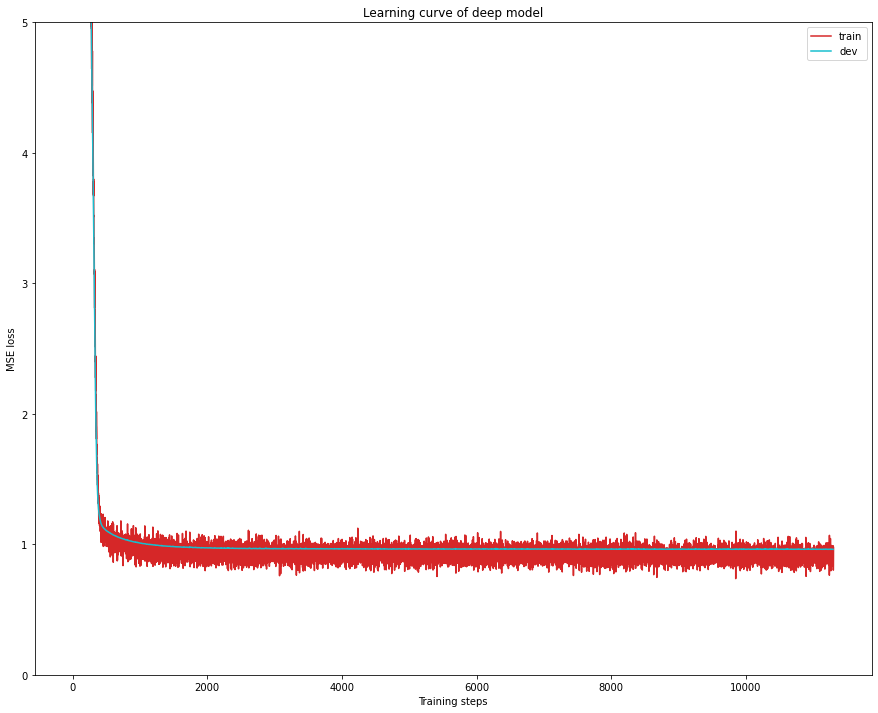

In [74]:
plot_learning_curve(model_loss_record, title='deep model')

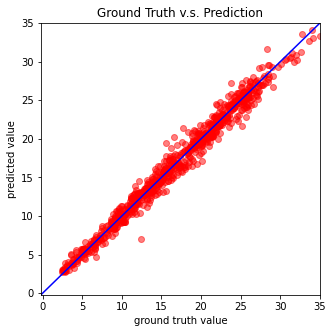

In [75]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [76]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
